In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

# 100 CAN Sequence

### Pre-processing

In [2]:
df = pd.read_csv('pre-attack-labeled/attack-free/attack-free-1.csv')

columns = ['timestamp', 'arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8', 'attack']

# Function to split each value into 8 bytes
def split_bytes(value):
    if pd.isna(value):
        return [None] * 8  # Return a list of Nones if the value is NaN
    value_str = str(value)
    bytes_list = [value_str[i:i+2] for i in range(0, len(value_str), 2)]
    return bytes_list

# Apply the function to create new columns
df_bytes = df['data_field'].apply(split_bytes).apply(pd.Series)

# Rename columns
df_bytes.columns = [f'byte_{i+1}' for i in range(df_bytes.shape[1])]

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, df_bytes], axis=1)


# Drop data_field
df = df.drop(["data_field"], axis= 1)

# Set new order to columns with attack label last
df = df[columns]

# hex to decimal
for i in columns:
    if i == 'attack' or i == 'timestamp' or i == 'arbitration_id':
        continue
    df[i] = df[i].astype(str).dropna().apply(lambda x: float.fromhex(x))

# Replace NaN values with 0
df.fillna(0, inplace=True)

df


,timestamp,arbitration_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,attack
0,1.672531e+09,6CF,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.672531e+09,075,0.0,0.0,0.0,0.0,0.0,4.0,14.0,129.0,0
2,1.672531e+09,0D0,121.0,254.0,0.0,0.0,0.0,0.0,255.0,255.0,0
3,1.672531e+09,0D1,0.0,0.0,3.0,128.0,0.0,0.0,0.0,0.0,0
4,1.672531e+09,070,0.0,128.0,0.0,255.0,238.0,127.0,14.0,187.0,0
...,...,...,...,...,...,...,...,...,...,...,...
807646,1.672532e+09,160,0.0,0.0,0.0,0.0,0.0,32.0,2.0,34.0,0
807647,1.672532e+09,161,40.0,35.0,130.0,255.0,0.0,32.0,0.0,236.0,0
807648,1.672532e+09,162,0.0,0.0,129.0,5.0,136.0,0.0,2.0,0.0,0
807649,1.672532e+09,163,0.0,0.0,80.0,0.0,0.0,2.0,0.0,7.0,0


## Scaling

In [3]:
scaler = MinMaxScaler()

columns_to_exclude = ['timestamp', 'arbitration_id', 'attack']
columns_to_scale = [col for col in df.columns if col not in columns_to_exclude]

# Fit and transform the columns to scale
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df

,timestamp,arbitration_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,attack
0,1.672531e+09,6CF,0.000000,0.160784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1.672531e+09,075,0.000000,0.000000,0.000000,0.000000,0.000000,0.015686,0.054902,0.505882,0
2,1.672531e+09,0D0,0.474510,0.996078,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0
3,1.672531e+09,0D1,0.000000,0.000000,0.011765,0.501961,0.000000,0.000000,0.000000,0.000000,0
4,1.672531e+09,070,0.000000,0.501961,0.000000,1.000000,0.933333,0.498039,0.054902,0.733333,0
...,...,...,...,...,...,...,...,...,...,...,...
807646,1.672532e+09,160,0.000000,0.000000,0.000000,0.000000,0.000000,0.125490,0.007843,0.133333,0
807647,1.672532e+09,161,0.156863,0.137255,0.509804,1.000000,0.000000,0.125490,0.000000,0.925490,0
807648,1.672532e+09,162,0.000000,0.000000,0.505882,0.019608,0.533333,0.000000,0.007843,0.000000,0
807649,1.672532e+09,163,0.000000,0.000000,0.313725,0.000000,0.000000,0.007843,0.000000,0.027451,0


# Create sequences

In [4]:
# Create sequences of length 100 with a stride of 50

# Parameters for the sliding window
sequence_length = 100
stride = 50

sequences = []

for start_pos in range(0, len(df) - sequence_length + 1, stride):
    end_pos = start_pos + sequence_length

    sequences.append(df.iloc[start_pos:end_pos].to_numpy())


df_sequences = np.array(sequences)

print(df_sequences.shape)

(16152, 100, 11)


In [5]:
df_sequences

array([[[1672531200.0, '6CF', 0.0, ..., 0.0, 0.0, 0],
        [1672531200.001458, '075', 0.0, ..., 0.054901960784313725,
         0.5058823529411764, 0],
        [1672531200.001671, '0D0', 0.4745098039215686, ..., 1.0, 1.0, 0],
        ...,
        [1672531200.054302, '140', 0.0, ..., 0.09803921568627451,
         0.6313725490196078, 0],
        [1672531200.054547, '141', 0.11372549019607843, ...,
         0.12549019607843137, 0.011764705882352941, 0],
        [1672531200.056394, '002', 0.00392156862745098, ..., 0.0, 0.0,
         0]],

       [[1672531200.024098, '576', 0.0, ..., 0.1843137254901961,
         0.12941176470588234, 0],
        [1672531200.024343, '140', 0.0, ..., 0.09803921568627451,
         0.12941176470588234, 0],
        [1672531200.024564, '141', 0.10980392156862745, ...,
         0.12549019607843137, 0.011764705882352941, 0],
        ...,
        [1672531200.084565, '141', 0.11372549019607843, ...,
         0.12549019607843137, 0.011764705882352941, 0],
        [16

In [6]:
arr = []
ls = []
for sequence in df_sequences[:, :, 1]:
  ls = []
  for elem in sequence:
    ls.append(int(elem, 16))
  arr.append(np.array(ls))

In [7]:
# store all ID in x
x = np.array(arr)

# Attach arbitration ID converted into the arb ID spot
df_sequences[:, :, 1] = x

arb_max = df_sequences[:, :, 1].max()
arb_max

df_sequences[:, :, 1] = (df_sequences[:, :, 1] - df_sequences[:, :, 1].min()) / arb_max
df_sequences

array([[[1672531200.0, 0.8731193580742227, 0.0, ..., 0.0, 0.0, 0],
        [1672531200.001458, 0.057673019057171516, 0.0, ...,
         0.054901960784313725, 0.5058823529411764, 0],
        [1672531200.001671, 0.10330992978936811, 0.4745098039215686,
         ..., 1.0, 1.0, 0],
        ...,
        [1672531200.054302, 0.15947843530591777, 0.0, ...,
         0.09803921568627451, 0.6313725490196078, 0],
        [1672531200.054547, 0.15997993981945838, 0.11372549019607843,
         ..., 0.12549019607843137, 0.011764705882352941, 0],
        [1672531200.056394, 0.0, 0.00392156862745098, ..., 0.0, 0.0, 0]],

       [[1672531200.024098, 0.7001003009027081, 0.0, ...,
         0.1843137254901961, 0.12941176470588234, 0],
        [1672531200.024343, 0.15947843530591777, 0.0, ...,
         0.09803921568627451, 0.12941176470588234, 0],
        [1672531200.024564, 0.15997993981945838, 0.10980392156862745,
         ..., 0.12549019607843137, 0.011764705882352941, 0],
        ...,
        [1672531200

In [8]:
df_sequences = df_sequences[:, :, [1, 2, 3,4,5,6,7,8,9]] #id, d[0]...d[7]

In [9]:
df_sequences

array([[[0.8731193580742227, 0.0, 0.16078431372549018, ..., 0.0, 0.0,
         0.0],
        [0.057673019057171516, 0.0, 0.0, ..., 0.01568627450980392,
         0.054901960784313725, 0.5058823529411764],
        [0.10330992978936811, 0.4745098039215686, 0.996078431372549,
         ..., 0.0, 1.0, 1.0],
        ...,
        [0.15947843530591777, 0.0, 0.054901960784313725, ..., 0.0,
         0.09803921568627451, 0.6313725490196078],
        [0.15997993981945838, 0.11372549019607843, 0.14901960784313725,
         ..., 0.5294117647058824, 0.12549019607843137,
         0.011764705882352941],
        [0.0, 0.00392156862745098, 0.5607843137254902, ..., 0.0, 0.0,
         0.0]],

       [[0.7001003009027081, 0.0, 0.0, ..., 0.14509803921568626,
         0.1843137254901961, 0.12941176470588234],
        [0.15947843530591777, 0.0, 0.043137254901960784, ..., 0.0,
         0.09803921568627451, 0.12941176470588234],
        [0.15997993981945838, 0.10980392156862745, 0.14901960784313725,
         ...,

In [10]:
df_sequences.shape

(16152, 100, 9)

In [75]:
# np.save('normal.npy', df_sequences)

# Training

In [11]:
from sklearn.model_selection import train_test_split
normal_sequences_train, normal_sequences_test = train_test_split(df_sequences, test_size = 0.35)
normal_sequences_train.shape,normal_sequences_test.shape

((10498, 100, 9), (5654, 100, 9))

In [12]:
import tensorflow as tf

In [13]:
normal_sequences_train_tf = tf.data.Dataset.from_tensor_slices((normal_sequences_train.astype('float32'), normal_sequences_train.astype('float32'))).batch(256)
normal_sequences_test_tf = tf.data.Dataset.from_tensor_slices((normal_sequences_test.astype('float32'), normal_sequences_test.astype('float32'))).batch(128)
normal_sequences_train_tf

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 9), dtype=tf.float32, name=None))>

In [14]:
def get_model(units=[256,256,256,256],num_layers=4,seq_len=100,seq_width=9):   
    inpt = tf.keras.layers.Input((seq_len,seq_width))
    x = tf.keras.layers.Conv1D(filters=100, kernel_size=3, strides=1,padding='same' ,activation='relu')(inpt)
    #x = Conv1D(filters=24, kernel_size=2, strides=1, padding="same", activation='relu')(x)

    x = tf.keras.layers.LSTM(units[0],activation='relu',return_sequences=True,unroll=True)(x)
    for i in range(num_layers-1):
        x = tf.keras.layers.LSTM(units[i+1],activation='relu',return_sequences=True,unroll=True)(x)
    out = tf.keras.layers.Dense(seq_width,activation='relu')(x)
    model = tf.keras.Model(inpt,out)

    return model

In [15]:
epochs = 2000
lr = 1e-4
opt = tf.keras.optimizers.Adam(lr)

In [16]:
model = get_model()
model.summary( )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 100)       │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 256)       │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 9)         │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,946,617 (7.43 MB)

 Trainable params: 1,946,617 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [18]:
cp = tf.keras.callbacks.ModelCheckpoint('model_checkpoint_2000.keras',monitor='loss',save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=200,restore_best_weights=True)
csv = tf.keras.callbacks.CSVLogger('train_log.csv')

In [ ]:
history = model.fit(normal_sequences_train_tf, epochs = epochs, validation_data= normal_sequences_test_tf,callbacks=[cp, es, csv] ,verbose = True)

In [ ]:
import pickle

with open('LSTM2000.pkl', 'wb') as file:
    pickle.dump(model, file)

model.save('LSTMmode2000')

In [ ]:
log = pd.read_csv('train_log.csv')

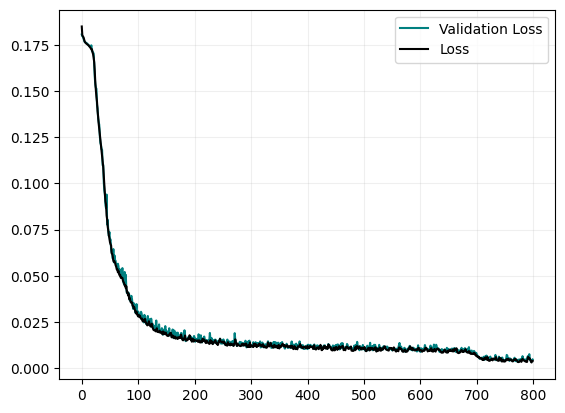

In [ ]:
plt.figure()
plt.plot(log['val_loss'],color='teal')
plt.plot(log['loss'],color='k')
plt.legend(['Validation Loss','Loss'])
plt.grid(alpha=0.2)
plt.show()

# Testing

### DoS

In [52]:
dos = pd.read_csv('post-attack-labeled/DoS-attacks/DoS-1.csv')

columns = ['timestamp', 'arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8', 'attack']
# Function to split each value into 8 bytes
def split_bytes(value):
    if pd.isna(value):
        return [None] * 8  # Return a list of Nones if the value is NaN
    value_str = str(value)
    bytes_list = [value_str[i:i+2] for i in range(0, len(value_str), 2)]
    return bytes_list

# Apply the function to create new columns
dos_bytes = dos['data_field'].apply(split_bytes).apply(pd.Series)

# Rename columns
dos_bytes.columns = [f'byte_{i+1}' for i in range(dos_bytes.shape[1])]

# Concatenate the new columns with the original DataFrame
dos = pd.concat([dos, dos_bytes], axis=1)


# Drop data_field
dos = dos.drop(["data_field"], axis= 1)

# Set new order to columns with attack label last
dos = dos[columns]

# Convert from hex to decimal
for i in columns:
    if i == 'attack' or i == 'timestamp' or i == 'arbitration_id':
        continue
    dos[i] = dos[i].astype(str).dropna().apply(lambda x: float.fromhex(x))

# Replace NaN values with 0
dos.fillna(0, inplace=True)

dos

,timestamp,arbitration_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,attack
0,1.672531e+09,152,249.0,164.0,0.0,0.0,0.0,0.0,16.0,140.0,0
1,1.672531e+09,164,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0
2,1.672531e+09,148,11.0,25.0,0.0,128.0,65.0,0.0,17.0,5.0,0
3,1.672531e+09,149,124.0,1.0,63.0,121.0,169.0,20.0,0.0,0.0,0
4,1.672531e+09,156,1.0,128.0,0.0,0.0,0.0,0.0,0.0,15.0,0
...,...,...,...,...,...,...,...,...,...,...,...
643802,1.672532e+09,141,124.0,42.0,222.0,43.0,160.0,5.0,0.0,2.0,0
643803,1.672532e+09,144,0.0,0.0,109.0,52.0,47.0,168.0,0.0,64.0,0
643804,1.672532e+09,148,11.0,25.0,157.0,133.0,65.0,0.0,102.0,5.0,0
643805,1.672532e+09,149,26.0,12.0,63.0,47.0,170.0,32.0,0.0,0.0,0


In [53]:
dos['attack'].value_counts()

0    631716
1     12091
Name: attack, dtype: int64

In [55]:
scaler = MinMaxScaler()

columns_to_exclude = ['timestamp', 'arbitration_id', 'attack']
columns_to_scale = [col for col in df.columns if col not in columns_to_exclude]

# Fit and transform the columns to scale
dos[columns_to_scale] = scaler.fit_transform(dos[columns_to_scale])

dos

,timestamp,arbitration_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,attack
0,1.672531e+09,152,0.976471,0.643137,0.000000,0.000000,0.000000,0.000000,0.062745,0.549020,0
1,1.672531e+09,164,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015686,0
2,1.672531e+09,148,0.043137,0.098039,0.000000,0.501961,0.254902,0.000000,0.066667,0.019608,0
3,1.672531e+09,149,0.486275,0.003922,0.247059,0.474510,0.662745,0.078431,0.000000,0.000000,0
4,1.672531e+09,156,0.003922,0.501961,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0
...,...,...,...,...,...,...,...,...,...,...,...
643802,1.672532e+09,141,0.486275,0.164706,0.870588,0.168627,0.627451,0.019608,0.000000,0.007843,0
643803,1.672532e+09,144,0.000000,0.000000,0.427451,0.203922,0.184314,0.658824,0.000000,0.250980,0
643804,1.672532e+09,148,0.043137,0.098039,0.615686,0.521569,0.254902,0.000000,0.400000,0.019608,0
643805,1.672532e+09,149,0.101961,0.047059,0.247059,0.184314,0.666667,0.125490,0.000000,0.000000,0


In [56]:
# Parameters for the sliding window
sequence_length = 100
stride = 50

sequences = []

for start_pos in range(0, len(dos) - sequence_length + 1, stride):
    end_pos = start_pos + sequence_length

    sequences.append(dos.iloc[start_pos:end_pos].to_numpy())


dos = np.array(sequences)

print(dos.shape)

(12875, 100, 11)


In [57]:
arr = []
ls = []
for sequence in dos[:, :, 1]:
  ls = []
  for elem in sequence:
    ls.append(int(elem, 16))
  arr.append(np.array(ls))

In [58]:
# store all ID in x
x = np.array(arr)

# Attach arbitration ID converted into the arb ID spot
dos[:, :, 1] = x

arb_max = dos[:, :, 1].max()

dos[:, :, 1] = (dos[:, :, 1] - dos[:, :, 1].min()) / arb_max
dos

array([[[1672531200.0, 0.16950852557673018, 0.9764705882352941, ...,
         0.06274509803921569, 0.5490196078431373, 0],
        [1672531200.00215, 0.17853560682046138, 0.01568627450980392,
         ..., 0.0, 0.01568627450980392, 0],
        [1672531200.00216, 0.16449348044132397, 0.043137254901960784,
         ..., 0.06666666666666667, 0.0196078431372549, 0],
        ...,
        [1672531200.063012, 0.1715145436308927, 0.00392156862745098,
         ..., 0.0, 0.058823529411764705, 0],
        [1672531200.063014, 0.0010030090270812437, 0.0, ..., 0.0, 0.0,
         0],
        [1672531200.064084, 0.058676028084252756, 0.0, ...,
         0.0392156862745098, 0.9607843137254902, 0]],

       [[1672531200.026294, 0.2778335005015045, 0.8509803921568627, ...,
         0.4980392156862745, 0.0, 0],
        [1672531200.027464, 0.7011033099297894, 0.0, ...,
         0.1568627450980392, 0.08235294117647059, 0],
        [1672531200.031954, 0.16449348044132397, 0.043137254901960784,
         ..., 0

### Creating Labels

In [60]:
dos_labels_new = []

# threshold for anomalous sequences (1%)
threshold = 0.01

# Iterate over each sequence in the dataset
for sequence in dos:
    # The attack column is the last (11th feature, index 10)
    # Count the number of anomalies (1s) in the last column of the sequence
    num_anomalies = np.sum(sequence[:, -1] == 1)
    
    # Percentage of anomalous arrays
    percentage_anomalous = num_anomalies / sequence.shape[0]
    
    # Assign label: 1 if more than 1% anomalous, otherwise 0
    if percentage_anomalous > threshold:
        dos_labels_new.append(1)
    else:
        dos_labels_new.append(0)

dos_labels_new = np.array(dos_labels_new)


num_anomalous_sequences = np.sum(dos_labels_new == 1)
num_normal_sequences = np.sum(dos_labels_new == 0)

print(f"Number of anomalous sequences (1): {num_anomalous_sequences}")
print(f"Number of normal sequences (0): {num_normal_sequences}")


Number of anomalous sequences (1): 579
Number of normal sequences (0): 12296


In [61]:
dos_labels_new

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
# This is to check which sequences are anomalous
indices_of_ones = np.where(dos_labels_new == 1)[0]

print("Indices of 1s in the array:", indices_of_ones)

Indices of 1s in the array: [4734 4735 4736 4737 4738 4739 4740 4741 4742 4743 4744 4745 4746 4747
 4748 4749 4750 4751 4752 4753 4754 4755 4756 4757 4758 4759 4760 4761
 4762 4763 4764 4765 4766 4767 4768 4769 4770 4771 4772 4773 4774 4775
 4776 4777 4778 4779 4780 4781 4782 4783 4784 4785 4786 4787 4788 4789
 4790 4791 4792 4793 4794 4795 4796 4797 4798 4799 4800 4801 4802 4803
 4804 4805 4806 4807 4808 4809 4810 4811 4812 4813 4814 4815 4816 4817
 4818 4819 4820 4821 4822 4823 4824 4825 4826 4827 4828 4829 4830 4831
 4832 4833 4834 4835 4836 4837 4838 4839 4840 4841 4842 4843 4844 4845
 4846 4847 4848 4849 4850 4851 4852 4853 4854 4855 4856 4857 4858 4859
 4860 4861 4862 4863 4864 4865 4866 4867 4868 4869 4870 4871 4872 4873
 4874 4875 4876 4877 4878 4879 4880 4881 4882 4883 4884 4885 4886 4887
 4888 4889 4890 4891 4892 4893 4894 4895 4896 4897 4898 4899 4900 4901
 4902 4903 4904 4905 4906 4907 4908 4909 4910 4911 4912 4913 4914 4915
 4916 4917 4918 4919 4920 4921 4922 4923 4924 492

In [39]:
dos = dos[:, :, [1, 2, 3,4,5,6,7,8,9]] #id, d[0]...d[7]
dos

array([[[0.16950852557673018, 0.9764705882352941, 0.6431372549019607,
         ..., 0.0, 0.06274509803921569, 0.5490196078431373],
        [0.17853560682046138, 0.01568627450980392, 0.0, ..., 0.0, 0.0,
         0.01568627450980392],
        [0.16449348044132397, 0.043137254901960784, 0.09803921568627451,
         ..., 0.0, 0.06666666666666667, 0.0196078431372549],
        ...,
        [0.1715145436308927, 0.00392156862745098, 0.5019607843137255,
         ..., 0.0, 0.0, 0.058823529411764705],
        [0.0010030090270812437, 0.0, 0.10588235294117647, ..., 0.0, 0.0,
         0.0],
        [0.058676028084252756, 0.0, 0.0, ..., 0.01568627450980392,
         0.0392156862745098, 0.9607843137254902]],

       [[0.2778335005015045, 0.8509803921568627, 0.16862745098039217,
         ..., 1.0, 0.4980392156862745, 0.0],
        [0.7011033099297894, 0.0, 0.0, ..., 0.12549019607843137,
         0.1568627450980392, 0.08235294117647059],
        [0.16449348044132397, 0.043137254901960784, 0.10980392156

In [40]:
dos_data_tf = tf.data.Dataset.from_tensor_slices(dos.astype('float32')).batch(32)
dos_data_tf

<_BatchDataset element_spec=TensorSpec(shape=(None, 100, 9), dtype=tf.float32, name=None)>

In [41]:
model = get_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 100)       │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 100, 256)       │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100, 9)         │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,946,617 (7.43 MB)

 Trainable params: 1,946,617 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model.load_weights('model_checkpoint_new.keras')

In [42]:
dos_reconstructions = model.predict(dos_data_tf)
dos_train_loss = tf.keras.losses.mae(dos_reconstructions, dos.astype('float32'))

403/403 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step


In [43]:
dos_train_loss = np.mean(dos_train_loss, axis = 1)
dos_train_loss.shape

(12875,)

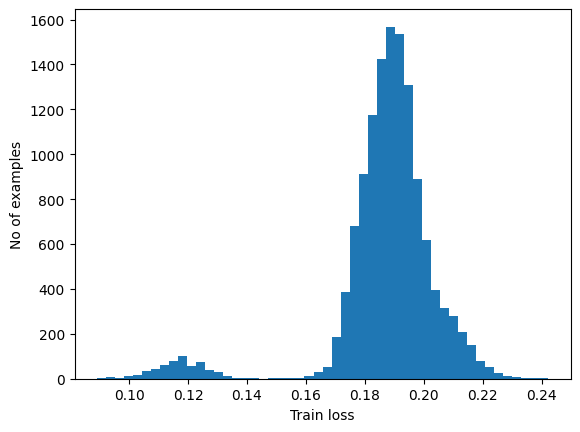

In [44]:
plt.hist(dos_train_loss, bins=50) #Plotting dos error distribution
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [48]:
threshold = 0.21

# Generate anomaly detection labels
anomaly_detection_labels = (dos_train_loss > threshold).astype(int)

anomaly_detection_labels

array([0, 0, 0, ..., 0, 1, 0])

In [49]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, matthews_corrcoef, accuracy_score

# True anomalies are the labels from the dataset
true_anomalies = dos_labels_new
predicted_anomalies = anomaly_detection_labels

# Calculating precision and recall
precision = precision_score(true_anomalies, predicted_anomalies)
recall = recall_score(true_anomalies, predicted_anomalies)

# Confusion matrix to calculate FPR and TPR
tn, fp, fn, tp = confusion_matrix(true_anomalies, predicted_anomalies).ravel()
fpr = fp / (fp + tn)  # False Positive Rate
tpr = tp / (tp + fn)  # True Positive Rate

# Matthew's Correlation Coefficient
mcc = matthews_corrcoef(true_anomalies, predicted_anomalies)

accuracy = accuracy_score(true_anomalies, predicted_anomalies)


precision, recall, fpr, tpr, mcc, accuracy

(0.0, 0.0, 0.05302537410540013, 0.0, -0.05011782860837495, 0.9043883495145632)

In [36]:
dos_labels = np.ones(len(dos))
dos_labels.shape

(6438,)

In [ ]:
test_data = np.concatenate([normal_sequences_test[:2000], dos])
test_data.shape

### Fuzzy

### RPM Spoof

### Gear Spoof